<a href="https://colab.research.google.com/github/SL-207/Multilabel-Apparel-Image-Classifier/blob/main/Multilabel_Apparel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Download dataset and Import dependencies

In [1]:
!kaggle datasets download -d trolukovich/apparel-images-dataset

Dataset URL: https://www.kaggle.com/datasets/trolukovich/apparel-images-dataset
License(s): CC0-1.0
 97% 241M/248M [00:04<00:00, 77.1MB/s]
100% 248M/248M [00:04<00:00, 60.1MB/s]


In [2]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile
from tqdm.auto import tqdm
from timeit import default_timer as timer
import re
import random

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms as T, datasets
from torch.utils.data import Dataset, random_split, DataLoader

In [17]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 2. Preprocess and Split Data

In [3]:
# Create paths and extract data
data_path = Path('data')
data_path.mkdir(exist_ok=True, parents=True)

with ZipFile('apparel-images-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(data_path)
    print('Data extracted successfully')

Data extracted successfully


In [5]:
os.listdir(data_path)

['blue_shoes',
 'blue_dress',
 'red_shoes',
 'red_dress',
 'blue_shorts',
 'white_dress',
 'black_shoes',
 'black_shorts',
 'white_pants',
 'blue_shirt',
 'white_shorts',
 'green_shoes',
 'white_shoes',
 'green_pants',
 'red_pants',
 'black_dress',
 'black_shirt',
 'brown_shoes',
 'blue_pants',
 'brown_shorts',
 'green_shorts',
 'green_shirt',
 'brown_pants',
 'black_pants']

In [4]:
class_names = ['black', 'blue', 'brown', 'green', 'white', 'red', 'dress', 'pants', 'shorts', 'shoes', 'shirt']
class_names

['black',
 'blue',
 'brown',
 'green',
 'white',
 'red',
 'dress',
 'pants',
 'shorts',
 'shoes',
 'shirt']

In [5]:
# Create transforms
train_transforms = T.Compose([
    T.Resize(size=(64, 64)),
    T.RandomHorizontalFlip(),
    T.TrivialAugmentWide(num_magnitude_bins=31),
    T.ToTensor()
])

test_transforms = T.Compose([
    T.Resize(size=(64, 64)),
    T.ToTensor()
])

In [6]:
# Create custom dataset class
# Preprocesses labels to one-hot encoding
class ApparelDataset(Dataset):
    def __init__(self, data_path, class_names: list[str], transform: torchvision.transforms=None):
        self.paths = list(data_path.glob('*/*.jpg'))
        self.classes = class_names
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image_path = self.paths[idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        multi_label = image_path.parent.stem # e.g. black_dress
        label = [1 if c in multi_label else 0 for c in class_names] # one-hot encoded target
        return image, torch.tensor(label, dtype=torch.float)

In [18]:
# Create and Split dataset
def preprocess(data_path,
               train_split: float,
               train_transform: torchvision.transforms,
               test_transform: torchvision.transforms,
               seed: int=None):
    dataset = ApparelDataset(data_path=data_path, class_names=class_names)

    train_size = int(len(dataset) * train_split)
    val_size = int((len(dataset) - train_size)/2)
    test_size = len(dataset) - train_size - val_size

    if seed:
        torch.manual_seed(seed)
    train_data, val_data, test_data = random_split(dataset=dataset, lengths=[train_size, val_size, test_size])
    train_data.dataset.transform = train_transform
    val_data.dataset.transform = test_transform
    test_data.dataset.transform = test_transform
    return train_data, val_data, test_data

train_data, val_data, test_data = preprocess(data_path=data_path,
                                             train_split=0.8,
                                             train_transform=train_transforms,
                                             test_transform=test_transforms,
                                             seed=SEED)
len(train_data), len(val_data), len(test_data)

(9108, 1138, 1139)

In [10]:
train_data[0]


(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [19]:
# Create dataloader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(SEED)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

In [12]:
print(f'Train: {len(train_dataloader)} batches of {train_dataloader.batch_size}')
print(f'Validation: {len(val_dataloader)} batches of {val_dataloader.batch_size}')
print(f'Test: {len(test_dataloader)} batches of {test_dataloader.batch_size}')

Train: 285 batches of 32
Validation: 36 batches of 32
Test: 36 batches of 32


In [20]:
images, labels = next(iter(train_dataloader))
images.shape, labels.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32, 11]))

### 3. Examine data

In [27]:
def decode_target(target: torch.tensor, class_names: list[str]):
    label_idxs = [i for i, t in enumerate(target) if t == 1]
    output_str = ''
    for l in label_idxs:
        output_str += class_names[l] + ' '

    return label_idxs, output_str.strip()

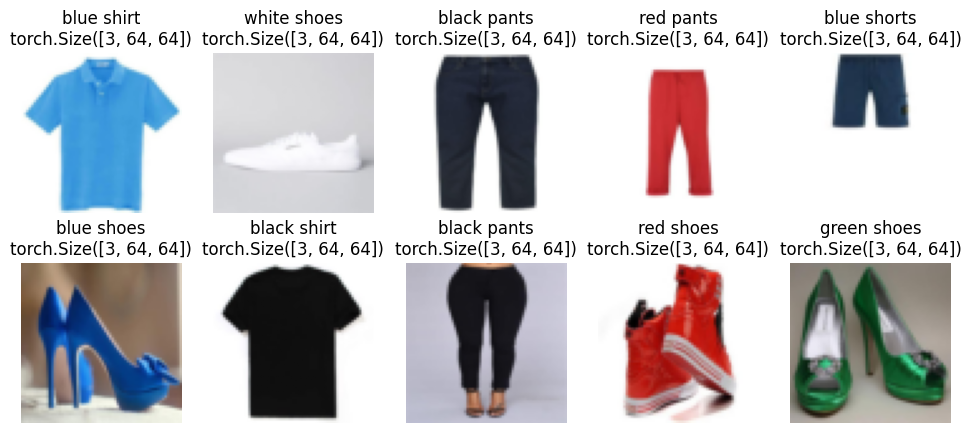

In [15]:
def plot_random_images(dataset: torch.utils.data.Dataset, n: int, show_shape: bool=True, seed: int=None):
    if seed:
        random.seed(seed)

    if n > 10:
        print(f'n exceeds maximum, setting n to 10')

    img_idxs = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(12, 5))
    for i, idx in enumerate(img_idxs):
        plt.subplot(2, 5, i+1)
        image = dataset[i][0]
        plt.imshow(image.permute(1, 2, 0))
        plt.axis(False)

        label_idxs, output_str = decode_target(target=dataset[i][1], class_names=class_names)
        title = output_str
        title += f'\n{image.shape}'
        plt.title(title)

plot_random_images(dataset=train_data, n=10)

### 4. Build model and train loops

In [48]:
preds = torch.tensor([[True, True],
        [True, False]])

actual = torch.tensor([[True, False],
        [True, False]])

(preds & actual).T.float().mean(1)

tensor([1., 0.])

In [31]:
def calc_fbeta(pred_probs, labels, threshold: int=0.5, beta: int=1):
    # Micro average
    pred_rounded = pred_probs > threshold
    labels = labels.type(torch.bool)
    TP = (pred_rounded & labels).sum(1).float()
    TN = ((~pred_rounded) & (~labels)).sum(1).float()
    FP = (pred_rounded & (~labels)).sum(1).float()
    FN = ((~pred_rounded) & labels).sum(1).float()

    epsilon = 1e-12 # prevent zero division
    precision = torch.mean(TP/(TP + FP + epsilon))
    recall = torch.mean(TP/(TP + FN + epsilon))

    fbeta = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + epsilon)
    return precision.mean(0), recall.mean(0), fbeta.mean(0)

In [72]:
class ApparelBase(nn.Module):
    def train_step(self,
                   batch: tuple,
                   loss_fn: torch.nn.Module,
                   optimizer,
                   l2_lambda: int=None,
                   gradient_clip: int=None,
                   device: torch.device='cpu'):
        b_images, b_labels = batch
        b_images, b_labels = b_images.to(device), b_labels.to(device)
        y_logits = self(b_images)
        loss = loss_fn(y_logits, b_labels)

        # Regularization
        if l2_lambda and l2_lambda >= 0:
            l2_norm = sum(w.pow(2).sum() for w in self.parameters())
            loss += l2_lambda * l2_norm

        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        if gradient_clip:
            nn.utils.clip_grad_value_(parameters=self.parameters(), clip_value=gradient_clip)

        optimizer.step()
        y_probs = torch.sigmoid(y_logits)
        prec, recall, f1_score = calc_fbeta(pred_probs=y_probs, labels=b_labels)

        return loss, f1_score

    def val_step(self,
                 val_dl,
                 loss_fn: torch.nn.Module,
                 threshold: int=0.5,
                 device: torch.device='cpu'):
        val_loss, val_f1 = 0, 0
        self.eval()
        with torch.inference_mode():
            for b_images, b_labels in val_dl:
                b_images, b_labels = b_images.to(device), b_labels.to(device)
                y_logits = self(b_images)
                val_loss += loss_fn(y_logits, b_labels).item()
                y_probs = torch.sigmoid(y_logits)
                prec, recall, f1_score = calc_fbeta(pred_probs=y_probs, labels=b_labels, threshold=threshold)
                val_f1 += f1_score

            val_loss /= len(val_dl)
            val_f1 /= len(val_dl)
        return val_loss, val_f1

In [71]:
class ApparelModel(ApparelBase):
    def __init__(self, input_channels: int, output_features: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=10, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.clf_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=10*16*16, out_features=output_features)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block(x)
        x = self.conv_block2(x)
        return self.clf_block(x)

In [13]:
model = ApparelModel(input_channels=3, output_features=len(class_names))
model

ApparelModel(
  (conv_block): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=11, bias=True)
  )
)

In [43]:
try:
    import torchinfo
except:
    !pip install -qq torchinfo

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
ApparelModel                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      28,171
Total params: 31,181
Trainable params: 31,181
Non-trainable params: 0

In [44]:
# Test inference
model.eval()
with torch.inference_mode():
    y_logits = model(images)
    y_probs = torch.sigmoid(y_logits)
    print(y_probs.shape)

torch.Size([32, 11])


In [54]:
def train(model: torch.nn.Module,
          train_dl: torch.utils.data.DataLoader,
          val_dl: torch.utils.data.DataLoader,
          epochs: int,
          loss_fn: torch.nn.Module,
          optimizer,
          l2_lambda: int=None,
          gradient_clip: int=None,
          device: torch.device='cpu',
          seed: int=None):
    if seed:
        torch.manual_seed(seed)
    model.to(device)

    results = {'train_loss': [],
               'train_f1': [],
               'val_loss': [],
               'val_f1': []}

    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch}\n------')
        train_loss, train_f1 = 0, 0
        model.train()
        for b, batch in enumerate(train_dl):
            b_loss, b_f1 = model.train_step(batch=batch,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            l2_lambda=l2_lambda,
                                            gradient_clip=gradient_clip,
                                            device=device)
            train_loss += b_loss
            train_f1 += b_f1
            if b % 142 == 0:
                print(f'Examined {b * train_dl.batch_size}/{len(train_dl.dataset)}')

        train_loss /= len(train_dl)
        train_f1 /= len(train_dl)

        val_loss, val_f1 = model.val_step(val_dl=val_dl, loss_fn=loss_fn, device=device)
        print(f'\nTrain loss {train_loss:.3f} | Train F1 {train_f1:.3f} | Validation loss {val_loss:.3f} | Validation F1 {val_f1:.3f}\n')

        results['train_loss'].append(train_loss.item())
        results['train_f1'].append(train_f1.item())
        results['val_loss'].append(val_loss)
        results['val_f1'].append(val_f1.item())

    return results

### 5. Train model

In [55]:
lr = 0.01
EPOCHS = 10
l2_lambda = 0.001
gradient_clip_val = None
momentum = 0.9

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)

start = timer()
results = train(model=model,
                train_dl=train_dataloader,
                val_dl=val_dataloader,
                epochs=EPOCHS,
                loss_fn=loss_fn,
                optimizer=optimizer,
                l2_lambda=l2_lambda,
                gradient_clip=gradient_clip_val,
                device=device,
                seed=SEED)
print(f'<< Train time: {timer()-start} seconds >>')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.468 | Train F1 0.000 | Validation loss 0.449 | Validation F1 0.000

Epoch 1
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.395 | Train F1 0.277 | Validation loss 0.311 | Validation F1 0.485

Epoch 2
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.290 | Train F1 0.614 | Validation loss 0.251 | Validation F1 0.657

Epoch 3
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.243 | Train F1 0.718 | Validation loss 0.216 | Validation F1 0.726

Epoch 4
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.219 | Train F1 0.756 | Validation loss 0.203 | Validation F1 0.762

Epoch 5
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.205 | Train F1 0.780 | Validation loss 0.183 | Validation F1 0.775

Epoch 6
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.190 | Train

In [56]:
results

{'train_loss': [0.4683275818824768,
  0.39455094933509827,
  0.29018646478652954,
  0.24255837500095367,
  0.21937157213687897,
  0.20492041110992432,
  0.18961751461029053,
  0.17467230558395386,
  0.16410501301288605,
  0.15560030937194824],
 'train_f1': [0.0,
  0.2766461968421936,
  0.6137099266052246,
  0.7177167534828186,
  0.7560792565345764,
  0.7795719504356384,
  0.80479496717453,
  0.8308550119400024,
  0.8470432758331299,
  0.8574097752571106],
 'val_loss': [0.44904062979751164,
  0.3106878192888366,
  0.25066275687681305,
  0.21583683747384283,
  0.2034900159471565,
  0.18343089355362785,
  0.1698687378731039,
  0.15305474607480896,
  0.14508452204366526,
  0.14894623143805397],
 'val_f1': [0.0,
  0.4851311147212982,
  0.6567223072052002,
  0.7257445454597473,
  0.7622631192207336,
  0.7746764421463013,
  0.8060209155082703,
  0.8304821252822876,
  0.8308145403862,
  0.8287789821624756]}

In [57]:
# Training more epochs
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)

start = timer()
results_2 = train(model=model,
                train_dl=train_dataloader,
                val_dl=val_dataloader,
                epochs=EPOCHS,
                loss_fn=loss_fn,
                optimizer=optimizer,
                l2_lambda=l2_lambda,
                gradient_clip=gradient_clip_val)
print(f'<< Train time: {timer()-start} seconds >>')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.151 | Train F1 0.864 | Validation loss 0.133 | Validation F1 0.864

Epoch 1
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.145 | Train F1 0.875 | Validation loss 0.130 | Validation F1 0.852

Epoch 2
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.142 | Train F1 0.877 | Validation loss 0.147 | Validation F1 0.831

Epoch 3
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.139 | Train F1 0.882 | Validation loss 0.131 | Validation F1 0.853

Epoch 4
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.136 | Train F1 0.887 | Validation loss 0.129 | Validation F1 0.860

Epoch 5
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.133 | Train F1 0.890 | Validation loss 0.123 | Validation F1 0.865

Epoch 6
------
Examined 0/9108
Examined 4544/9108
Examined 9088/9108

Train loss 0.132 | Train

### 6. Save and Reload model

In [64]:
import copy
results_comb = copy.deepcopy(results)
for key, val in results_2.items():
    results_comb[key].extend(val)

In [73]:
model_path = Path('models')
model_path.mkdir(exist_ok=True, parents=True)
save_dict = {'state_dict': model.state_dict(),
             'results': results_comb}
torch.save(save_dict, f=model_path/'apparel_model.pt')

model_load = ApparelModel(input_channels=3, output_features=len(class_names))
load_dict = torch.load(f=model_path/'apparel_model.pt')
model_load.load_state_dict(load_dict['state_dict'])

<All keys matched successfully>

### 7. Evaluate model and training

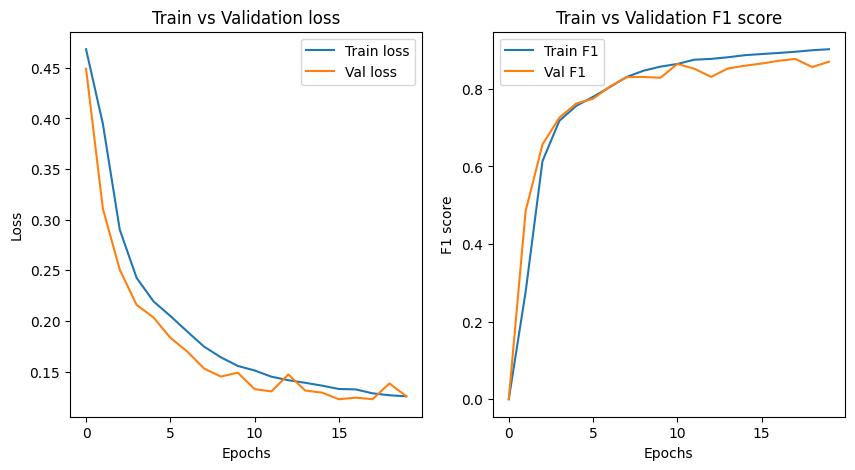

In [67]:
# Plot training performance
def plot_model_results(results: dict, epochs: int):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), results['train_loss'], label='Train loss')
    plt.plot(range(epochs), results['val_loss'], label='Val loss')
    plt.title('Train vs Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), results['train_f1'], label='Train F1')
    plt.plot(range(epochs), results['val_f1'], label='Val F1')
    plt.title('Train vs Validation F1 score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 score')
    plt.legend()

plot_model_results(results=load_dict['results'], epochs=20)

- Loss curve steadily decreases
- No major overfitting

n exceeds limit: setting to maximum


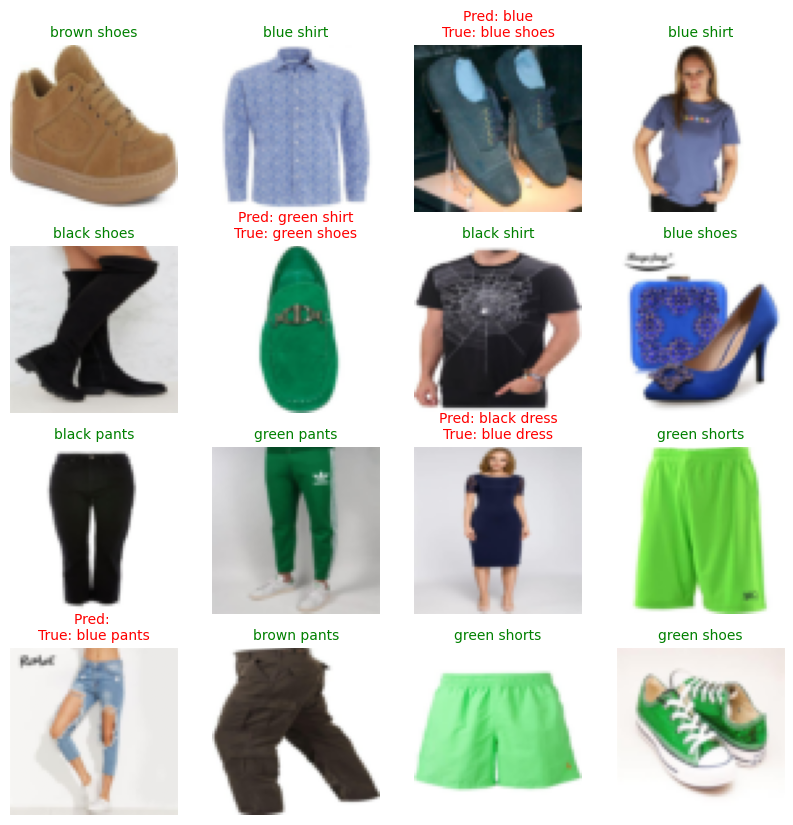

In [30]:
def make_plot_predictions(model: torch.nn.Module,
                          dataset: torch.utils.data.Dataset,
                          n: int,
                          class_names: list[str],
                          device: torch.device='cpu',
                          seed: int=None):
    if seed:
        random.seed(seed)

    if n > 16:
        n = 16
        print(f'n exceeds limit: setting to maximum')

    selected_idxs = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(selected_idxs):
        image, label = dataset[idx]
        plt.subplot(4, 4, i+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.axis(False)

        title = ''
        model.eval()
        with torch.inference_mode():
            y_logits = model(image.unsqueeze(0).to(device))
            y_probs = torch.sigmoid(y_logits).squeeze(0)
            label_idx, label_str = decode_target(torch.round(y_probs), class_names)
            true_idx, true_str = decode_target(label, class_names)
            if true_str == label_str:
                plt.title(f'{true_str}', c='g', fontsize=10)
            else:
                plt.title(f'Pred: {label_str}\nTrue: {true_str}', c='r', fontsize=10)

make_plot_predictions(model=model_load, dataset=test_data, n=17, class_names=class_names)

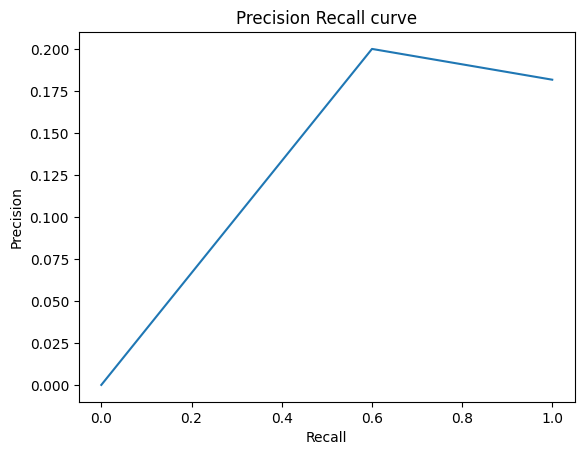

In [66]:
def precision_recall_curve(model: torch.nn.Module,
                        dataloader: torch.utils.data.DataLoader):
    model.eval()
    th_metrics = torch.zeros(size=(2, 11)) # inclusive 0-1
    with torch.inference_mode():
        for b_images, b_labels in dataloader:
            y_logits = model(b_images)
            y_probs = y_logits.sigmoid()
            for i, threshold in enumerate(range(11)):
                threshold /= 10 # convert to float threshold
                precision, recall, f1_score = calc_fbeta(pred_probs=y_probs, labels=b_labels, threshold=threshold)
                th_metrics[0][i] += precision
                th_metrics[1][i] += recall

        th_metrics /= len(dataloader)
        plt.plot(th_metrics[1], th_metrics[0])
        plt.title('Precision Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()

precision_recall_curve(model=model, dataloader=test_dataloader)

In [78]:
# Evaluate model on test
test_loss, test_f1 = model_load.val_step(test_dataloader, loss_fn, threshold=0.4)
print(f'Test loss {test_loss} | Test F1 {test_f1}')

Test loss 0.09231709378461044 | Test F1 0.9146456122398376
